In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)

<module 'local_radon' from '../src\\local_radon.py'>

D:/Data/bujo_sample\20190309_125151.jpg
Wall time: 774 ms


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


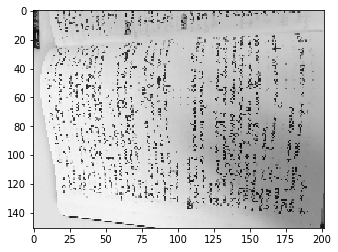

In [486]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)
plt.imshow(src2, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text angles is 0.0
Text line delta is 9
Wall time: 891 ms


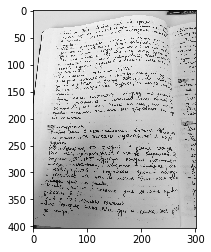

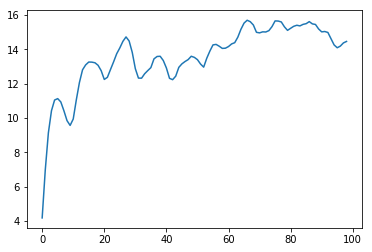

In [487]:
%%time
text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
srcr = skimage.transform.rotate(src, -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

Wall time: 76.1 ms


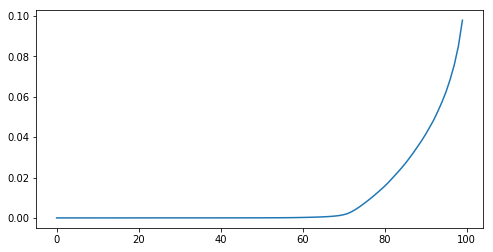

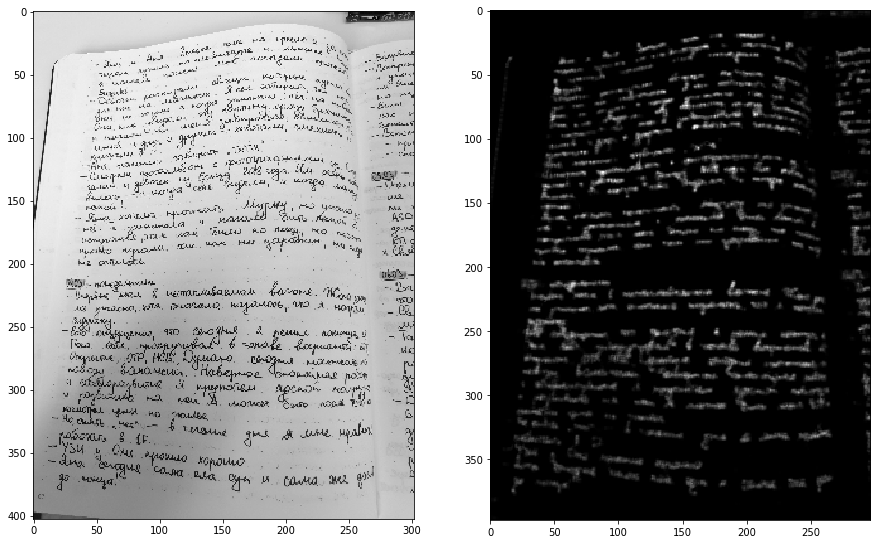

In [488]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 111 ms


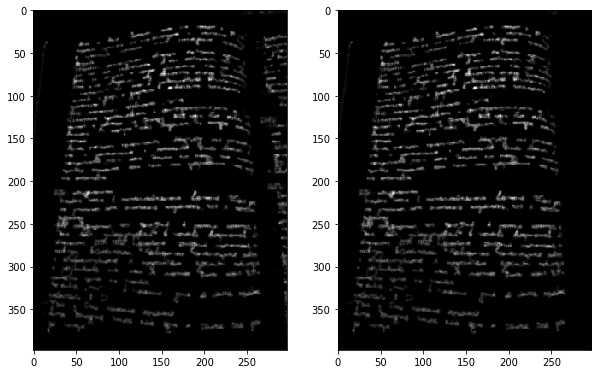

In [489]:
%%time
src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)
print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

Wall time: 268 ms


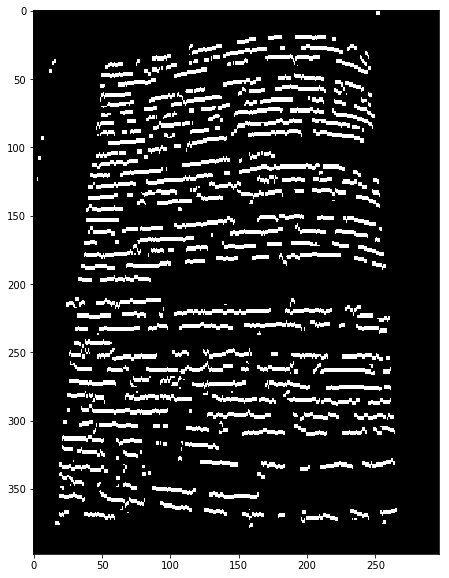

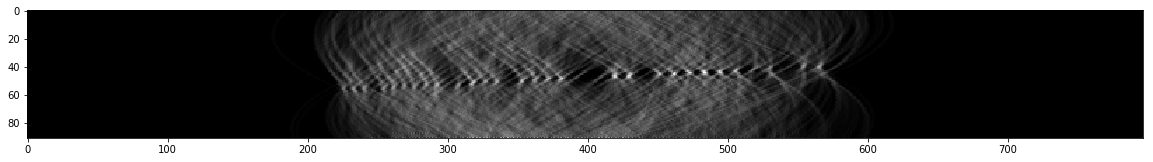

In [490]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

theta = np.linspace(-np.pi/4, np.pi/4, 91)
rgrid = local_radon.create_grid(src8, theta)
src9 = local_radon.calc_local_radon(rgrid, src8, 0, src8.shape[0], 0, src8.shape[1])

plt.figure(figsize=(8,10))
plt.imshow(src8, cmap='gray')

plt.figure(figsize=(20,10))
plt.imshow(src9, cmap='gray')

In [491]:
def calc_local_radon_angle(grid, flt, i0, i1, j0, j1):
    vals = grid[i0:i1, j0:j1, :][flt[i0:i1, j0:j1]>0, :]
    angs = [np.sum(np.power(np.unique(v, return_counts=True)[1], 2)) for v in vals.T]
    return np.argmax(angs)

def find_local_angle(src, grid, angles, i0, i1, j0, j1, reg_coef=0.2, reg_power=1.0):
    ang = angles[calc_local_radon_angle(grid, src, i0, i1, j0, j1)]
    pct = np.power(min(1, np.mean(src[i0:i1,j0:j1])/reg_coef), reg_power)
    return ang * pct

def make_curve_1way(i0, j0, step, src, grid, angles, kernel_size, reg_coef, reg_power):
    isz = kernel_size[0]//2
    jsz = kernel_size[1]//2
    def calc_angle(i, j):
        r_i0 = max(0, i-isz)
        r_i1 = min(src.shape[0], i+isz+1)
        r_j0 = max(0, j-jsz)
        r_j1 = min(src.shape[1], j+jsz+1)
        return find_local_angle(src, grid, angles, r_i0, r_i1, r_j0, r_j1, reg_coef, reg_power)
    
    res = [(i0, j0)]
    while True:
        ci, cj = res[-1]
        angle0 = calc_angle(ci, cj)
        di = step * np.sin(-angle0) * 0.5
        dj = step * np.cos(-angle0) * 0.5
        angle = calc_angle(int(np.round(ci+di)), int(np.round(cj+dj)))
        di = step * np.sin(-angle)
        dj = step * np.cos(-angle)
        ni = int(np.round(ci+di))
        nj = int(np.round(cj+dj))
        if ni < 0 or ni >= src.shape[0] or nj < 0 or nj >= src.shape[1]:
            ri = max(0, min(src.shape[0]-1, ni))
            rj = max(0, min(src.shape[1]-1, nj))
            
            rdi = 1.0
            rdj = 1.0
            if np.abs(di) > 1e-5:
                rdi = (ri - ci) / di
            if np.abs(dj) > 1e-5:
                rdj = (rj - cj) / dj
                
            rstep = min(rdi, rdj) * 0.9
            
            ni = int(np.round(ci+di*rstep))
            nj = int(np.round(cj+dj*rstep))
            res.append((ni, nj))            
            break
        
        res.append((ni, nj))
    return res

def make_curve_2way(i0, j0, step, src, grid, angles, kernel_size, reg_coef, reg_power):
    crv_p = make_curve_1way(i0, j0, step, src, grid, angles, kernel_size, reg_coef, reg_power)
    crv_n = make_curve_1way(i0, j0, -step, src, grid, angles, kernel_size, reg_coef, reg_power)
    return crv_n[:0:-1]+crv_p

def get_range(src, q, axis):
    tmp = np.mean(src, axis=axis)
    val = np.percentile(tmp, q)
    inds = np.arange(len(tmp))[tmp>val]
    return (min(inds), max(inds))

def get_max_points(src, i0, i1, window, stride):
    res = []
    for i in range(i0, i1, stride):
        res.append(i+np.argmax(src[i:(i+window)]))
    return np.array(res)

def interpolate_between_curves(crv1, crv2, a):
    j0 = min(np.min(crv1[:,1]), np.min(crv2[:,1]))
    j1 = max(np.max(crv1[:,1]), np.max(crv2[:,1]))
    j_s = np.arange(j0, j1)
    i1_s = np.interp(j_s, crv1[:,1], crv1[:,0])
    i2_s = np.interp(j_s, crv2[:,1], crv2[:,0])
    return j_s, np.minimum(src.shape[0]-1, np.maximum(0, np.floor(0.5+i1_s*(1-a)+a*i2_s))).astype(int)

def move_curve(crv, a):
    j0 = np.min(crv[:,1])
    j1 = np.max(crv[:,1])
    j_s = np.arange(j0, j1)
    i_s = np.floor(0.5+np.interp(j_s, crv[:,1], crv[:,0])).astype(int)+a
    return j_s, np.minimum(src.shape[0]-1, np.maximum(0, i_s))

def integrate_between_curves(src, crv1, crv2):
    j_s = np.arange(src.shape[1])
    i1_s = np.interp(j_s, crv1[:,1], crv1[:,0])
    i2_s = np.interp(j_s, crv2[:,1], crv2[:,0])
    num = np.max(np.abs(i1_s-i2_s))
    alphas = np.linspace(0, 1, num)
    ias = [np.minimum(src.shape[0]-1, np.maximum(0, np.floor(0.5+i1_s*(1-a)+a*i2_s))) for a in alphas]
    return np.array([np.sum(src[i_s.astype(int), j_s]) for i_s in ias]), alphas

def integrate_over_curve(src, crv, dvs):
    j_s = np.arange(src.shape[1])
    i_s = np.floor(0.5+np.interp(j_s, crv[:,1], crv[:,0])).astype(int)
    return np.array([np.sum(src[np.minimum(src.shape[0]-1, np.maximum(0, i_s+d)), j_s]) for d in dvs]), dvs

def integrate_curves(src, curves):
    res0 = []
    res1 = []
    df = np.min(curves[0][:,0])
    irf, dsf = integrate_over_curve(src, curves[0], -np.arange(df)[::-1])
    res0 += irf.tolist()
    res1 += [(d, curves[0]) for d in dsf]
    for (c1,c2) in zip(curves[:-1], curves[1:]):
        ir_s, a_s = integrate_between_curves(src, c1, c2)
        res0 += ir_s.tolist()
        res1 += [(c1, c2, a) for a in a_s]
    dl = src.shape[0]-np.max(curves[-1][:,0])
    irl, dsl = integrate_over_curve(src, curves[-1], np.arange(dl))
    res0 += irl.tolist()
    res1 += [(d, curves[-1]) for d in dsl]
    return np.array(res0), res1

def select_text_lines(arr1d, window_size, min_value, minmax_ratio):
    ids0 = local_radon.get_local_maximas_1d(arr1d, window_size, min_value)
    ids1 = []
    msk = (ids0[1:]==(ids0[:-1]+1))
    i = 0
    while i < len(ids0):
        k = 0
        while i < len(msk) and msk[i]:
            i += 1
            k += 1
        
        ids1.append(ids0[i-k//2])
        i += 1
        
    ids1 = [i for i in ids1 if max(np.min(arr1d[max(0, i-window_size):(i+1)]),np.min(arr1d[i:min(len(arr1d), i+window_size+1)]))/arr1d[i] < minmax_ratio]
    
    ids2 = []
    i = 0
    while i < len(ids1):
        if i < len(ids1)-1:
            if abs(ids1[i]-ids1[i+1]) < window_size and arr1d[ids1[i+1]]>arr1d[ids1[i]]:
                i += 1
                continue
        if i > 0:
            if abs(ids1[i]-ids1[i-1]) < window_size and arr1d[ids1[i-1]]>arr1d[ids1[i]]:
                i += 1
                continue
        ids2.append(ids1[i])
        i += 1
    return ids2

Wall time: 881 ms


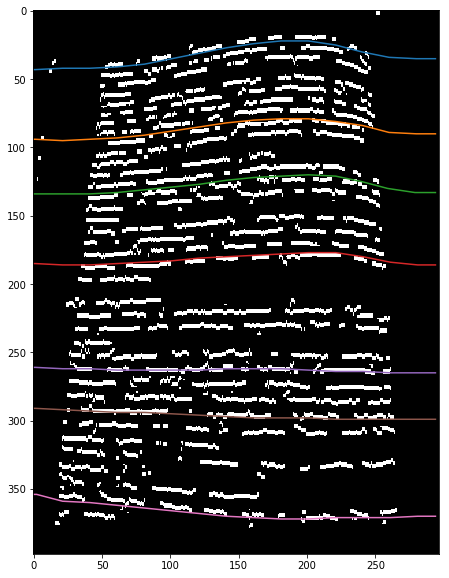

In [492]:
%%time
plt.figure(figsize=(8,10))
plt.imshow(src8, cmap='gray')
rj0, rj1 = get_range(src8, 50, 0)
ri0, ri1 = get_range(src8[:,rj0:rj1], 75, 1)
src8h = np.mean(src8[:,rj0:rj1], axis=1)
rows = np.concatenate(([ri0], get_max_points(src8h, ri0+30, ri1-30, 30, 60), [ri1]))
curves = [np.array(make_curve_2way(i, (rj0+rj1)//2, 20, src8, rgrid, theta, (40, 50), reg_coef=0.125, reg_power=1.0)) for i in rows]
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Wall time: 94.1 ms


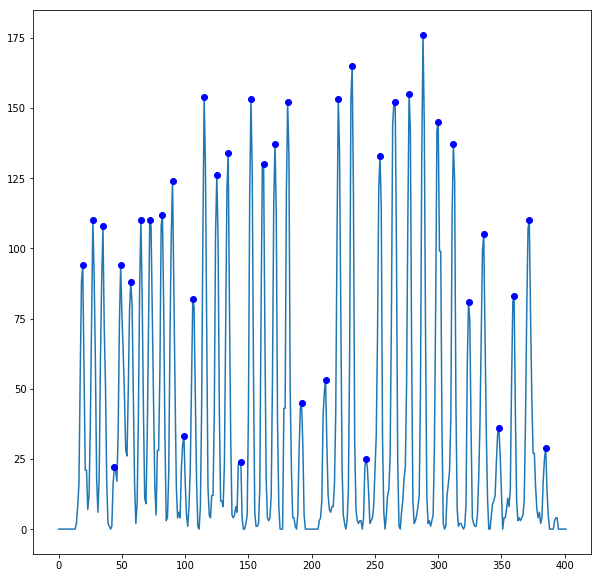

In [493]:
%%time
ires, imeta = integrate_curves(src8, curves)
ids = select_text_lines(ires, 5, 10, minmax_ratio=0.8)

plt.figure(figsize=(10,10))
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')

Wall time: 118 ms


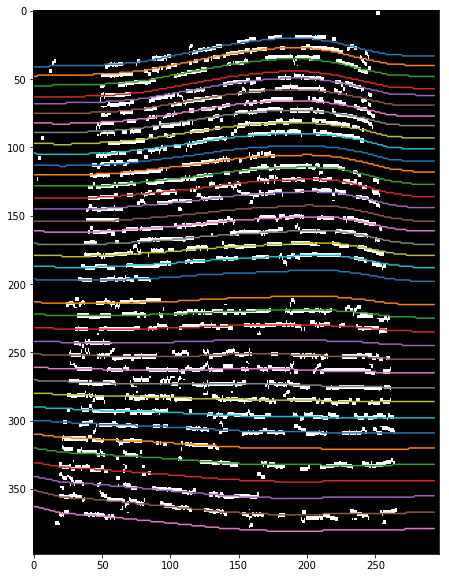

In [494]:
%%time
plt.figure(figsize=(8,10))
plt.imshow(src8, cmap='gray')
for i in ids:
    if type(imeta[i][0]) is np.ndarray:
        tmp_j, tmp_i = interpolate_between_curves(imeta[i][0], imeta[i][1], imeta[i][2])
    else:
        tmp_j, tmp_i = move_curve(imeta[i][1], imeta[i][0])
    plt.plot(tmp_j, tmp_i)
    #print(type(imeta[i][0]))